In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.linalg import svd

# Read the CSV file
titanic_data = pd.read_csv('dataset/train.csv')

# Rename the data to a dataframe for semantics
df = titanic_data

# Let's see what the attribute values are:
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [30]:
# First let's explore the initial data where the task asks us to view any issues with outliers:

# Drop passengerId, survived and Pclass columns because they don't have any outliers, they are more categorical or unqiue identifier
numerical_columns = df.drop(columns=['PassengerId', 'Survived','Pclass'])

# Get the summary statistics of the numerical columns
numerical_columns = numerical_columns.select_dtypes(include=[np.number])
summary_statistics = numerical_columns.describe()

# Display the summary statistics
print(summary_statistics)

              Age       SibSp       Parch        Fare
count  714.000000  891.000000  891.000000  891.000000
mean    29.699118    0.523008    0.381594   32.204208
std     14.526497    1.102743    0.806057   49.693429
min      0.420000    0.000000    0.000000    0.000000
25%     20.125000    0.000000    0.000000    7.910400
50%     28.000000    0.000000    0.000000   14.454200
75%     38.000000    1.000000    0.000000   31.000000
max     80.000000    8.000000    6.000000  512.329200


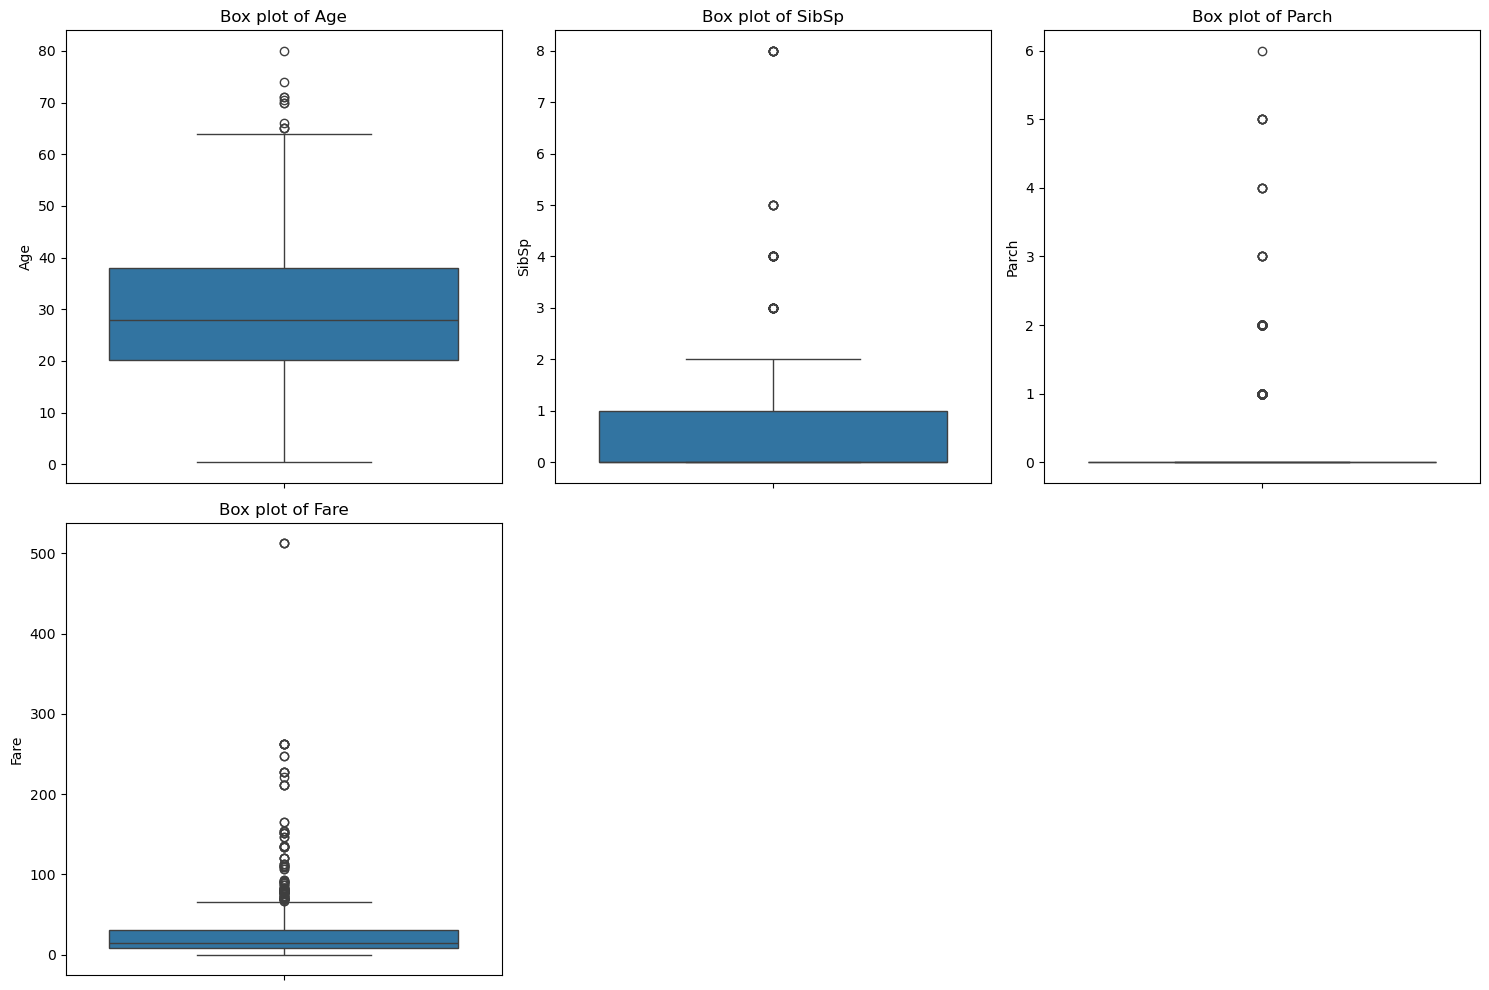

In [31]:
# Plot box plots for each numerical column to visualize outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns.columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, y=column)
    plt.title(f'Box plot of {column}')
    plt.tight_layout()

plt.show()

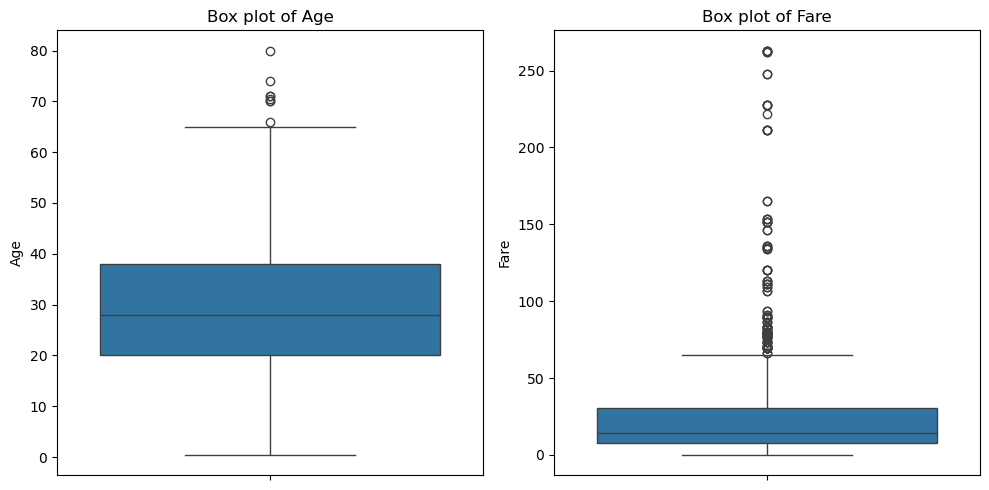

In [32]:
# We can see from the boxplots that parch and sibsp have most values clustered around 0 and the rest are basically outliers. There's not much
# interest in continuing with these columns as they don't provide much information. We can drop these columns.
numerical_columns = df.drop(columns=['Parch','SibSp'])

# The age and fare attributes on the other hand are much more interesting. We can see that there are some outliers in the data.
# values above the highest whiskers represent the outliers and with age the ones slightly above 60 are outliers and with the fare
# the ones above around 80 look to be outliers.

# I believe that the outliers are still fundamental when it comes to analysis of survivability of a passenger and age and fare prices
# are believed to be important factors, so we want to keep these. Only outlier I would remove would be the fare price of 512.3292.

# Code below to remove the observation with the fare price of 512.3292 as this is a significant outlier almost twice as much as the next highest fare price.
df = df[df.Fare <= 500]

# Select only the Age and Fare columns for plotting
columns_to_plot = ['Age', 'Fare']

# Plot box plots again
plt.figure(figsize=(10, 5))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 2, i)  # Adjust subplot grid to 1x2
    sns.boxplot(data=df, y=column)
    plt.title(f'Box plot of {column}')
    plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'Histogram of Age')

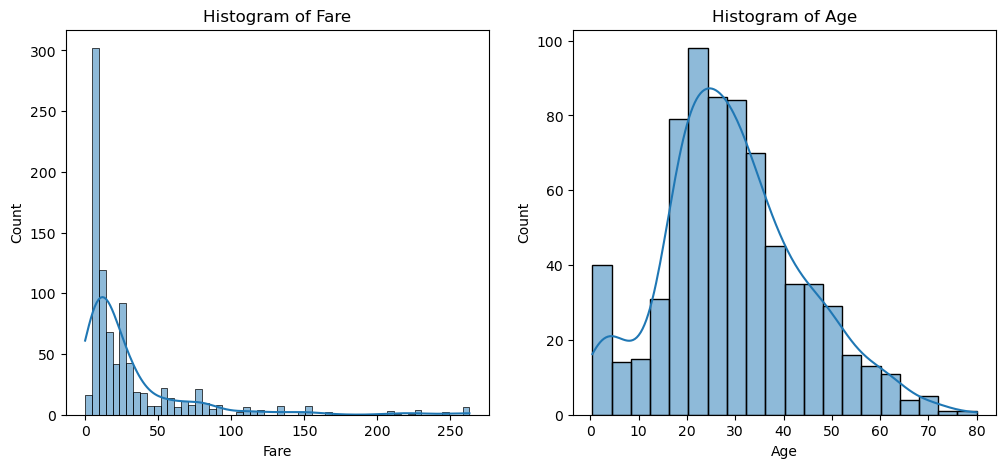

In [33]:
# Do the attributes appear to be normal distributed?

# In order to determine that, we first need to observe our dataset and check if the observations in each attribute are CONTINUOUS.
# This is because the normal distribution is continuous and from previous analysis in question 2), we see that age and fare
# are two continuous attributes.

# One simple way to acknowledge if the data is normally distributed is to plot a histogram
# Plot histogram for Fare
plt.figure(figsize=(12, 5))

# plot.subplot(1, 2, 1) means 1 row, 2 columns, and the first plot
plt.subplot(1, 2, 1)
sns.histplot(df['Fare'].dropna(), kde=True)
plt.title('Histogram of Fare')

# Plot histogram for Age
plt.subplot(1, 2, 2)
sns.histplot(df['Age'].dropna(), kde=True)
plt.title('Histogram of Age')

In [34]:
# We can see that the result above shows that the data is not very normally distributed. Age is slightly bell shaped, but it
# skews slightly to the right whilst the fare distribution is HEAVILY skewed to the right. This is due to the numerous
# outliers present in the attributes. If we want to normally distribute them more, we would have to log transform to reduce skewness.

# Are variables correlated?
# We can use a correlation matrix to determine if the variables are correlated, but before that we need to encode categorical
# variables to numerical ones. There are several categorical variables, but sex and pClass are believed to be the most significant
# in determining survivability of a passenger.

# Make another copy of the dataframe
cor_df = df

# Code below to encode sex whilst pClass is already numerical
label_encoder = LabelEncoder()
cor_df.loc[:,'Sex'] = label_encoder.fit_transform(df['Sex'])

# Drop columns that are not of significance
cor_df = df.drop(columns=['PassengerId','Name', 'Ticket', 'Cabin','Embarked'])

# Compute the correlation matrix
correlation_matrix = cor_df.corr()

# Display the correlation matrix
print(correlation_matrix)

          Survived    Pclass       Sex       Age     SibSp     Parch      Fare
Survived  1.000000 -0.334068 -0.545899 -0.079472 -0.033395  0.082157  0.261742
Pclass   -0.334068  1.000000  0.132881 -0.368625  0.080937  0.018212 -0.604960
Sex      -0.545899  0.132881  1.000000  0.093296 -0.114799 -0.247003 -0.222361
Age      -0.079472 -0.368625  0.093296  1.000000 -0.307639 -0.189194  0.100396
SibSp    -0.033395  0.080937 -0.114799 -0.307639  1.000000  0.415141  0.211816
Parch     0.082157  0.018212 -0.247003 -0.189194  0.415141  1.000000  0.263910
Fare      0.261742 -0.604960 -0.222361  0.100396  0.211816  0.263910  1.000000


In [35]:
# Above we can see the correlation matrix of the various attributes together.
# We can see that when it comes to sex and survived, we can see that there is a moderate negative correlation of -0.54.
# This suggests that passengers being male (encoded as 1) are less likely to survive. There is also a negative correlation of 
# class and survival, which suggests that passengers in higher classes are more likely to survive. Finally the fare has a
# relatively moderate positive correlation with survival, which suggests that passengers who paid more for their fare
# are more likely to survive.

# Does the primary machine learning modeling aim appear to be feasible based on your visualizations?

# This dataset is primarily a classification problem, where we are trying to predict whether a passenger survived or not.
# Here the target variable is survived which has a binary outcome, making it suitable for classification problems.

# Based on the correlation matrix results, we can see that there are some attributes that are correlated with the target variable
# and most are explained in the first paragraph in this cell. Through visualization, we can see that the age and fares are relatively
# normally distributed but skewed, especially fares, which could affect the model's performance, which might necessitate
# a transformation such as log transformation to reduce skewness.

# Classification is the most feasible given the correlation matrix and the visualizations we have done so far, which could include
# models such as logistic regression and decision trees.

# Linear regression could be used to explore the relationship between age and fare, although given the skewness and the weak positive
# correlation between the two, it might require some additional data manipulation to improve the model's performance.

In [36]:
# First thing we need to do is to clean the data to prepare it for PCA. Remember, PCA works on numerical data, 
# whilst most of the attributes below are qualitative.
# Drop columns that are not useful for PCA or have too many missing values
df_clean = df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])

# Probably better ways to do this, but for now imma just drop the rows with missing values
df_clean = df_clean.dropna()

# Convert categorical variables into dummy/indicator variables
# Converts a category attribute like sex and embarked into a binary attribute. This creates a column sex_male and drops sex_female as
# it's redundant, either its true or not. Embarked has value S, C or Q so it creates embarked q and s, dropping embarked c as it's redundant,
# done by drop_first=true.
df_clean = pd.get_dummies(df_clean, columns=['Sex', 'Embarked'], drop_first=True)

# Let's see how the dataset looks like now:
print(df_clean.head())

   Survived  Pclass   Age  SibSp  Parch     Fare  Sex_1  Embarked_Q  \
0         0       3  22.0      1      0   7.2500   True       False   
1         1       1  38.0      1      0  71.2833  False       False   
2         1       3  26.0      0      0   7.9250  False       False   
3         1       1  35.0      1      0  53.1000  False       False   
4         0       3  35.0      0      0   8.0500   True       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  


In [37]:
# The attributes above are of interest when it comes to the target variable being survivability and we can see that we have no more 
# missing attributes that are not numerical.

# One last thing before we apply PCA, we need to standardize the data. This is because PCA is sensitive to the scale of the data.
# One reason is that if we compare age to fare, age can vary from 0 to 100, whilst fare can vary from 0 to 1000. This means that
# the variance in the data is dominated by fare. We need to standardize the data so that the variance in the data is not dominated
# by one attribute. We can do this by subtracting the mean and dividing by the standard deviation of each attribute! 

# Standardize the data using the StandardScaler import, mathematically this is fairly simple, as it involves Z scoring the data
# with Z = (X - myu) / sigma. This forms the basis of a normal distribution.
scaler = StandardScaler()
# fit calculates the mean and standard deviation of each attribute and transform applies the Z score formula to each attribute.
df_standardized = scaler.fit_transform(df_clean)

# Let's see how it looks like now:
print(df_standardized)

[[-0.81985963  0.90464078 -0.52506921 ...  0.75634786 -0.20277082
   0.52894555]
 [ 1.21972099 -1.49308002  0.57772613 ... -1.32214296 -0.20277082
  -1.89055377]
 [ 1.21972099  0.90464078 -0.24937037 ... -1.32214296 -0.20277082
   0.52894555]
 ...
 [ 1.21972099 -1.49308002 -0.73184333 ... -1.32214296 -0.20277082
   0.52894555]
 [ 1.21972099 -1.49308002 -0.24937037 ...  0.75634786 -0.20277082
  -1.89055377]
 [-0.81985963  0.90464078  0.16417788 ...  0.75634786  4.93167604
  -1.89055377]]


In [38]:
# All the values above show how many standard deviations away from the mean the data is. Notice how there's one value that is 4.94
# standard deviations away from the mean. This is an outlier that we should take into account when we do PCA.

# Another thing to note is that by standardizing the data, we don't need to do
# Y = df_standardized - np.mean(df_standardized, axis=0) anymore because standardizing already transforms the attribute so that the mean is 0.

# Let's finally perform PCA via Single Value Decomposition svd:
U, S, Vt = svd(df_standardized, full_matrices=False)

# Compute variance explained by principal components
# For example: if S is [3, 2, 1] then S * S is [9, 4, 1] and (S * S).sum() is 9 + 4 + 1 = 14.
# rho is [9/14, 4/14, 1/14] = [0.64, 0.29, 0.07] where we get the variance explained by each principal component!
rho = (S * S) / (S * S).sum()

# Let's see how much variance is explained by the first 3 principal components:
print("The first principal component explains", rho[0] * 100, "% of the variance.")
print("The second principal component explains", rho[1] * 100, "% of the variance.")
print("The third principal component explains", rho[2] * 100, "% of the variance.")


The first principal component explains 25.311582231215894 % of the variance.
The second principal component explains 19.373585280337558 % of the variance.
The third principal component explains 15.200345453427452 % of the variance.


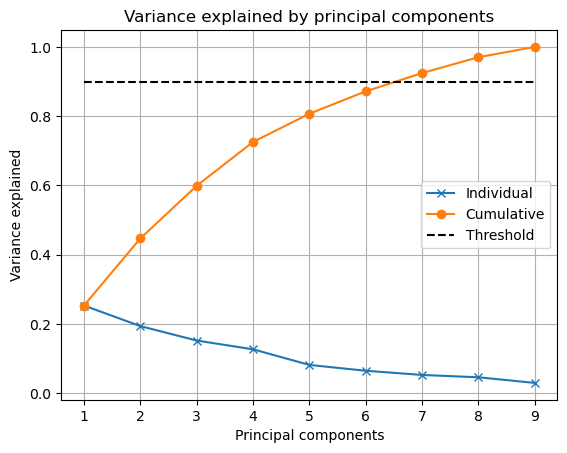

In [39]:
# We can see that the first three principle components are ordered from highest to lowest variance explained.
# Usually we want to define a threshold, which in our case will be 90% of the variance explained.

threshold = 0.9

# Let's try to visualize this better via plots:
plt.figure()
# First plot shows the variance explained by each principal component
plt.plot(range(1, len(rho) + 1), rho, "x-")
# Second will show the cumulative variance explained by the principal components
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
# Let's now add the threshold
plt.plot([1, len(rho)], [threshold, threshold], "k--")
# Add a title
plt.title("Variance explained by principal components")
# Label the axis
plt.xlabel("Principal components")
plt.ylabel("Variance explained")
# Add legend and grid as visual aid
plt.legend(["Individual", "Cumulative", "Threshold"])
plt.grid()

Principal directions 1 - 7:
          0         1         2         3         4         5         6
0  0.455455 -0.457589  0.038203  0.150868  0.250352  0.512659 -0.418343
1 -0.005131 -0.400613  0.563250 -0.510466 -0.452356  0.084931  0.186335
2 -0.023341  0.124021 -0.038500 -0.051926 -0.130117 -0.091428 -0.012132
3 -0.532181 -0.200543  0.210577  0.407874  0.262400  0.382339  0.485859
4  0.110926 -0.152440 -0.623144  0.135432 -0.518809  0.185240  0.343188
5 -0.106948  0.124865 -0.204303 -0.594533  0.525387  0.070379  0.154082
6 -0.138925  0.170370  0.325338  0.373156 -0.130272 -0.273310 -0.274635
7  0.611287 -0.094247  0.181148  0.191157  0.257248 -0.405730  0.557452
8 -0.303412 -0.705539 -0.258375 -0.002969  0.136282 -0.544833 -0.162377


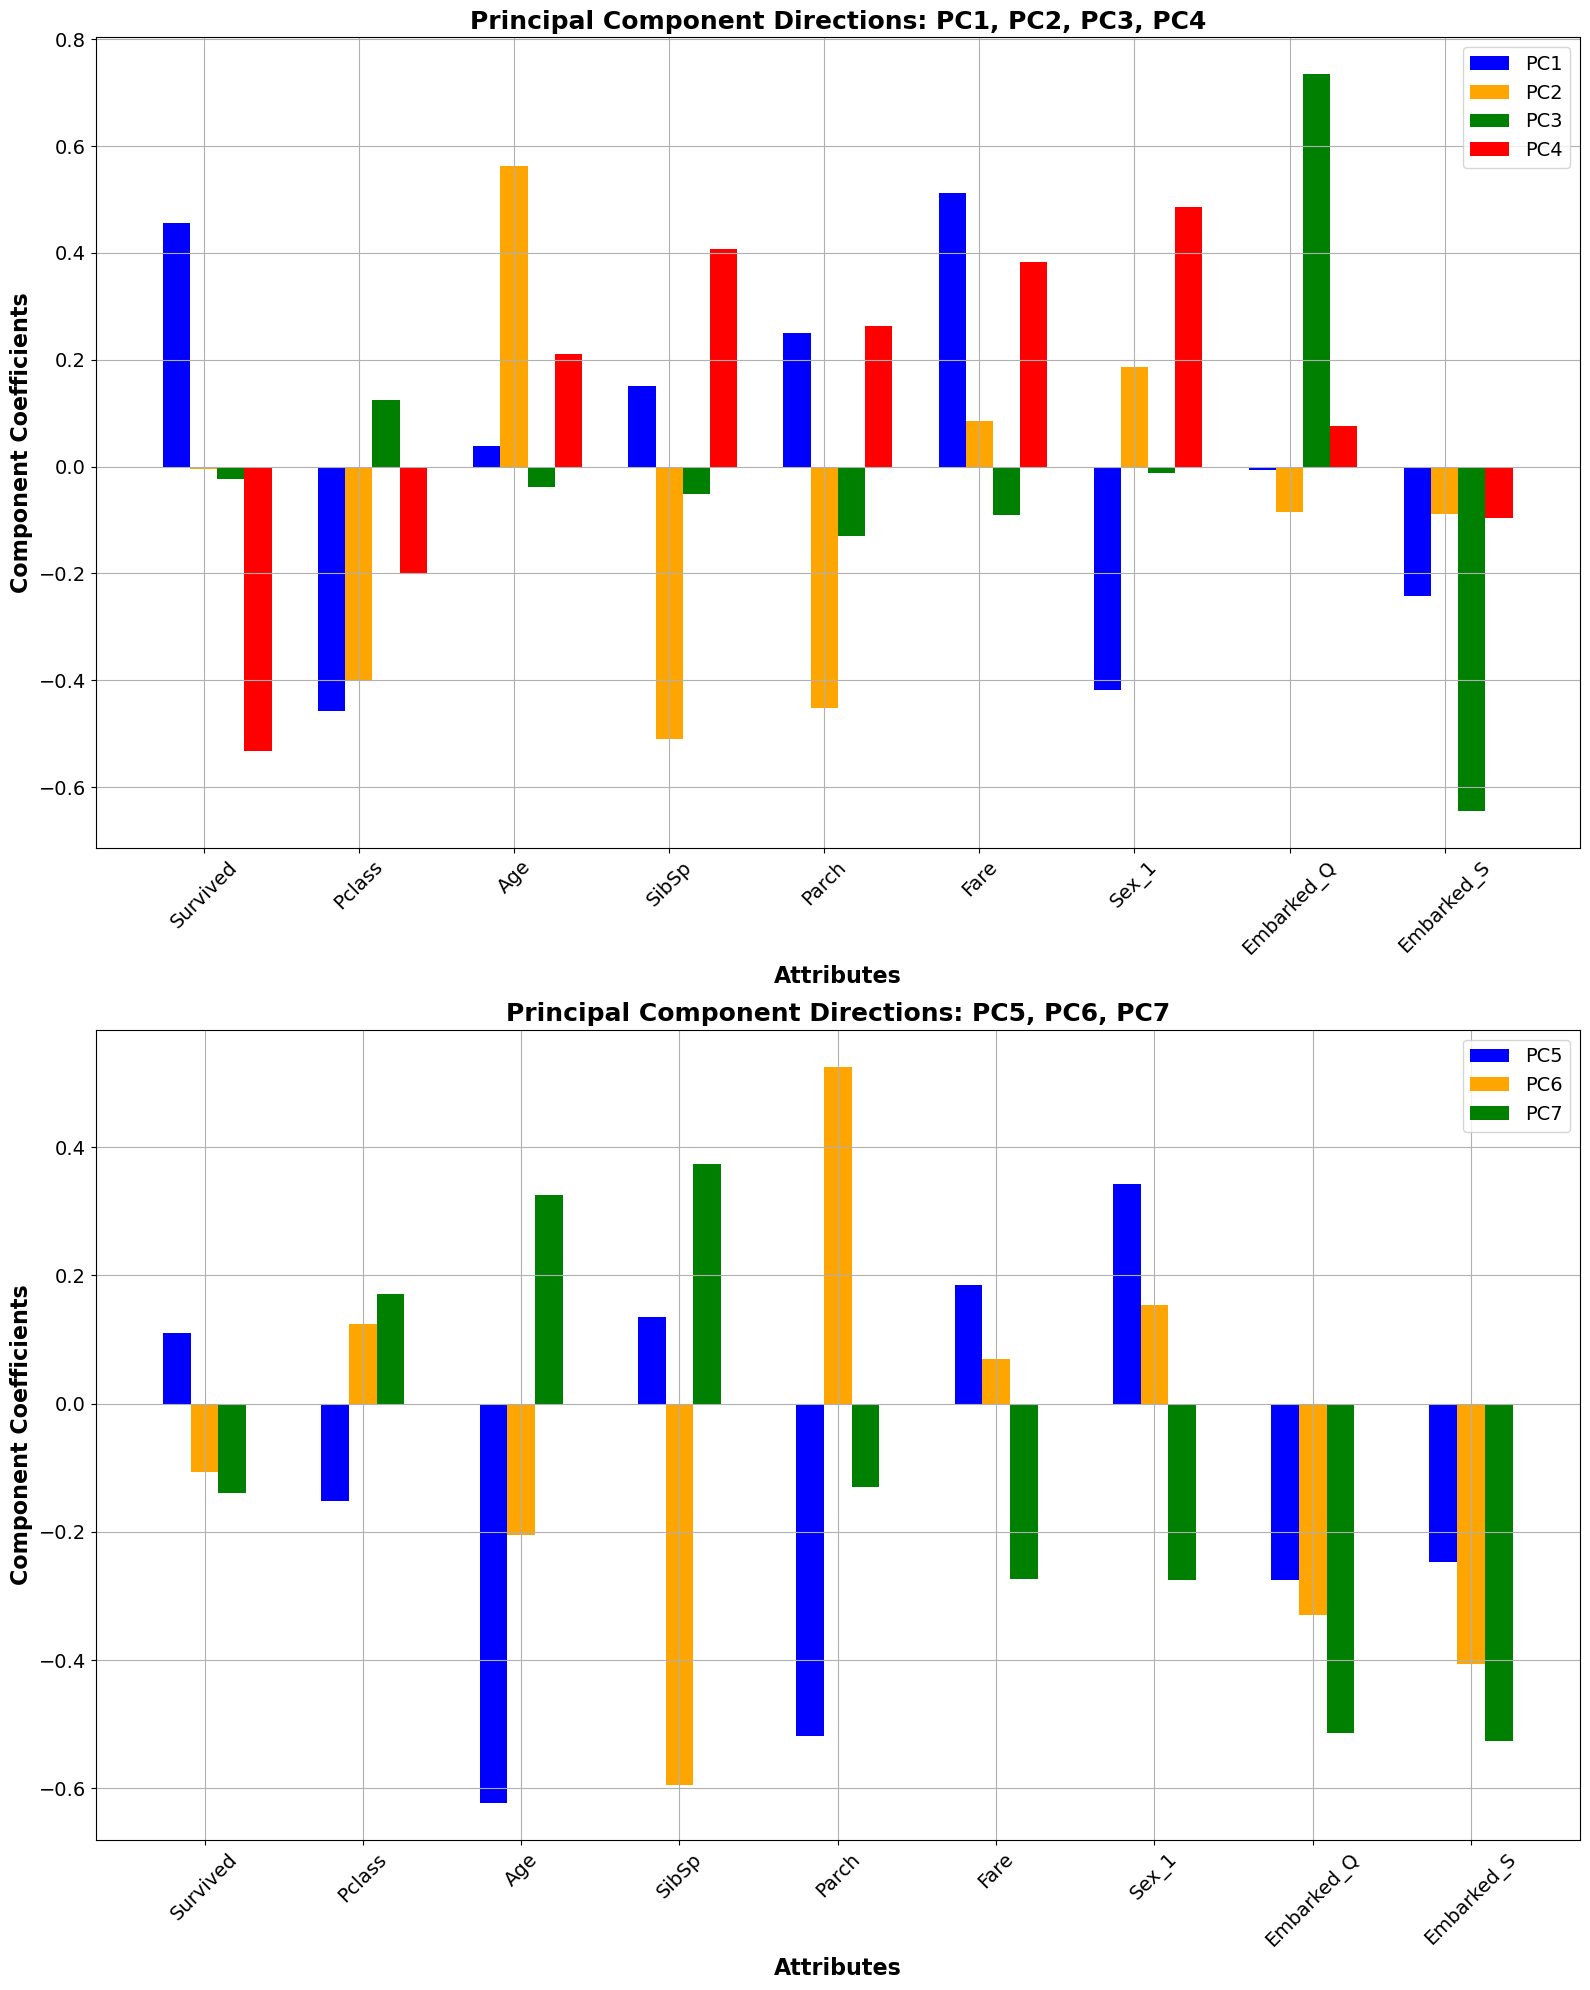

In [40]:
# How can we interpret this result? It's obvious from the graph above that we need at least 7 principal components to explain at least 90% of the variance,
# which is 2 less dimensions than the cleaned dataset and 6 less dimensions than the original dataset. This is a reduction in dimensionality whilst still
# being able to explain most of the spread of the original data!

# Unfortunately we can only visualize up to 3D data, which in this dataset only amounts to 60% of the variance explained. This is the tradeoff of PCA,
# we lose some information but we gain interpretability and computational efficiency!

# Describe the principle directions of the considered PCA components (either find a way to plot them or interpret them 
# in terms of the features)

# Remeber earlier, we performed the svd U, S, Vt = svd(df_standardized, full_matrices=False)
# Now we extract the Vt, which is a matrix that contains the vectors defining the principle directions.
principal_directions = Vt.T

# Begin by printing how to principle directions look like
print("Principal directions 1 - 7:")

# Convert the principal directions to a DataFrame for better formatting
principal_directions_df = pd.DataFrame(principal_directions)

# Transpose the DataFrame to show each principal direction as a column
principal_directions_df = principal_directions_df.T

# Print the DataFrame
print(principal_directions_df.iloc[:, :7])

# Set the components to plot in each subplot
pcs_top = [0, 1, 2, 3]  # First four principal components
pcs_bottom = [4, 5, 6]  # Fifth, sixth, and seventh principal components

# Start by configuring the plot
legendStrs_top = ["PC" + str(e + 1) for e in pcs_top]
legendStrs_bottom = ["PC" + str(e + 1) for e in pcs_bottom]
colors_top = ["b", "orange", "g", "r"]
colors_bottom = ["b", "orange", "g"]
bar_width = 0.175
# Below simply creates an array from 0 to the number of principal directions
r = np.arange(principal_directions.shape[0])

# Create the figure with two subplots
plt.figure(figsize=(16, 20))

# First Subplot: PC1, PC2, PC3, PC4
plt.subplot(2, 1, 1)
for i, pc in enumerate(pcs_top):
    # r + i * bar_width calculates the positions of the bars on the x_axis and we plot on the y axis the principal directions of each vector
    plt.bar(r + i * bar_width, principal_directions[:, pc], width=bar_width, color=colors_top[i], label=legendStrs_top[i])

# Config the plots more with labels and titles
plt.xticks(r + bar_width, df_clean.columns, rotation=45, fontsize=14) 
plt.yticks(fontsize=14)  
plt.xlabel("Attributes", fontsize=16, fontweight='bold')  
plt.ylabel("Component Coefficients", fontsize=16, fontweight='bold') 
plt.title("Principal Component Directions: PC1, PC2, PC3, PC4", fontsize=18, fontweight='bold')
plt.legend(fontsize=14)
plt.grid(True)

# Second Subplot: PC5, PC6, PC7
plt.subplot(2, 1, 2)
for i, pc in enumerate(pcs_bottom):
    plt.bar(r + i * bar_width, principal_directions[:, pc], width=bar_width, color=colors_bottom[i], label=legendStrs_bottom[i])

plt.xticks(r + bar_width, df_clean.columns, rotation=45, fontsize=14) 
plt.yticks(fontsize=14)  
plt.xlabel("Attributes", fontsize=16, fontweight='bold')  
plt.ylabel("Component Coefficients", fontsize=16, fontweight='bold') 
plt.title("Principal Component Directions: PC5, PC6, PC7", fontsize=18, fontweight='bold') 
plt.legend(fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()

How can we interpret this? Each principle direction is an eigenvector orthonormal to each other where the direction yields the maximized variance of the
projected datapoints. The first principle component always yields the highest proportion of the variance captures. This then tapers as we move onto the next 
few principle components. 

The bars represent the contributions of each feature to the principle component, where the sign either positive or negative and magnitude of these coefficients
indicate the direction and strength of each feature's contribution. A positive bar means that the feature contributes positively to the component and vice versa.
Magnitude shows the strenght of each contribution.

Remember that the PCs seem to capture the variances of these patterns the most in each principle component.

PC1: Attributes like "Survived", "Sex_1", "Fare" and "pClass" have relatively high positive coefficients, suggesting they are key factors driving the variance captured by PC1. These attributes seem to explain variances concerning socioeconomic status, with survivability being driven by higher class, higher fare prices and not being male.

PC2: The main attribute with the highest magnitude seems to be the positive age. It looks like higher age is associated with higher pClass, not travelling with children, siblings as well as being male and slightly increased fare prices.

PC3: Seems to capture where a person is embarked and it seems like the underlying pattern is that if a person embarked from Q, they certaintly didn't from S.

PC4: Seems to revolve around not surviving the journey and the other bar charts are relatively moderate indicating that if a person was a middleclass male, 
there seems to be a downward forcing survivability rate.

PC5: Here the underlying pattern seems to be that if a person is young, there seems to be an inverse relationship with number of parents children aboard. 

PC6: Looks like this principle component captures the relationship mostly between instances of parents / children aboard and number of siblings aboard, which makes
sense as parents with children onboard would often have several children with them.

PC7: Difficult to interpret, maybe a pattern of how a person embarked?

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.601119 -0.629406 -0.254474  0.299565  0.506450 -0.340026  0.136214   
1  2.686560  0.897990  0.805582 -0.281035  0.573398 -0.315784  1.238534   
2  0.053959 -0.322481 -0.233166 -2.169556 -0.294913 -0.295310  0.108448   
3  1.876640  0.528845 -0.706440 -0.717566  0.024512 -1.285645  0.014605   
4 -1.719307  0.424923 -0.234925  0.057462 -0.193853  0.116547  0.021988   

        PC8       PC9  
0 -0.092667 -0.140593  
1  0.010376  0.203326  
2 -0.166234 -0.498547  
3 -0.049888  0.455963  
4 -0.143157 -0.379075  


<Figure size 1000x800 with 0 Axes>

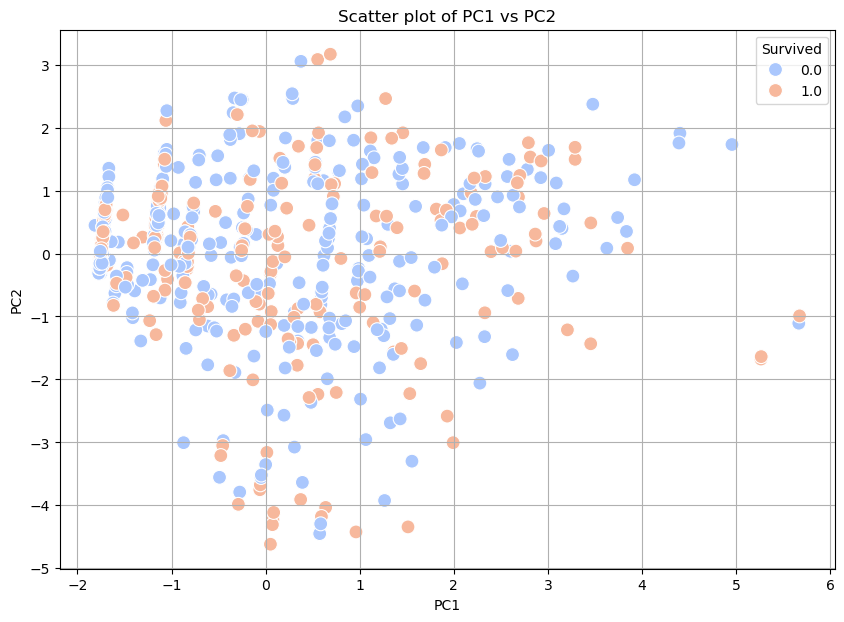

In [41]:
# Now we need to describe the data projected onto the considered principle component

# Project the data onto the principal components We could also do projected_data = df_standardized @ principal_directions instead of scores = U * S
# The scores (projected data) are already given by U * S
scores = U * S  # This scales U by the singular values, giving the principal component scores

# Convert the projected data into a DataFrame for easier interpretation
projected_df = pd.DataFrame(scores, columns=[f'PC{i+1}' for i in range(scores.shape[1])])

# Display the first few rows of the projected data
print(projected_df.head())

# Let's visualize the projection onto the first two principal components
plt.figure(figsize=(10, 8))

# Scatter plot of the first two principal components
plt.figure(figsize=(10, 7))
sns.scatterplot(x=projected_df['PC1'], y=projected_df['PC2'], hue=df_clean['Survived'], palette='coolwarm', s=100)
plt.title('Scatter plot of PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()


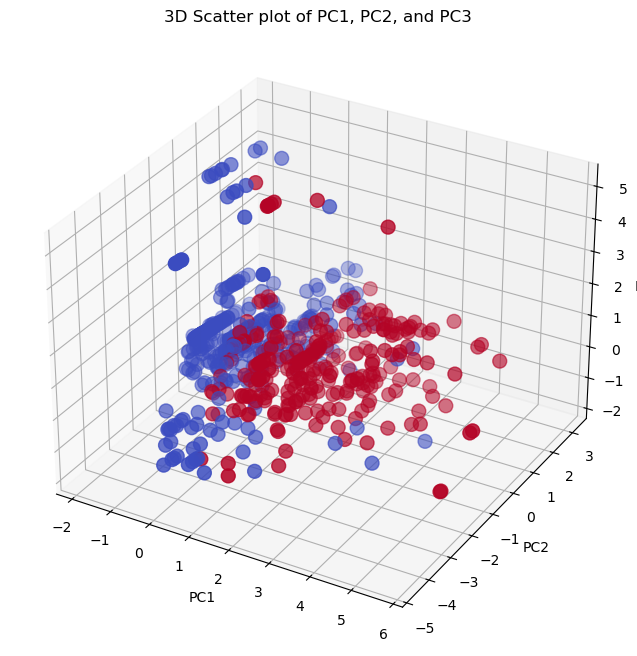

In [42]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D Scatter plot of the first three principal components
ax.scatter(projected_df['PC1'], projected_df['PC2'], projected_df['PC3'], c=df_clean['Survived'], cmap='coolwarm', s=100)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D Scatter plot of PC1, PC2, and PC3')
plt.show()